# Tutorial sobre Mapas de Rádio

Neste notebook, você aprenderá como:

- Calcular e configurar mapas de rádio
- Visualizar diferentes métricas de mapa de rádio, como ganho de caminho, força do sinal recebido (RSS - Received Signal Strength) e relação sinal-interferência-mais-ruído (SINR - Signal-to-Interference-plus-Noise Ratio)
- Interpretar a associação usuário-transmissor baseada em mapa de rádio
- Entender os efeitos dos vetores de pré-codificação em mapas de rádio
- Amostrar posições de usuários a partir de um mapa de rádio de acordo com vários critérios
- Gerar respostas impulsivas do canal para posições de usuários amostradas

## Imports

In [ ]:
# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

# Other imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

no_preview = True # Toggle to False to use the preview widget

# Import relevant components from Sionna RT
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies

In [ ]:
!pip install mitsuba
!pip install sionna-rt


In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Import or install Sionna
try:
    import mitsuba as mi
except ImportError as e:
    import os
    os.system("pip install mitsuba")
    import mitsuba as mi

# Import or install Sionna
%matplotlib inline
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

from sionna.rt import load_scene, Camera, Transmitter, Receiver, PlanarArray,\
                      PathSolver, RadioMapSolver, load_mesh, watt_to_dbm, transform_mesh,\
                      cpx_abs_square

no_preview = True # Toggle to False to use the preview widget
                  # instead of rendering for scene visualization

## Entendendo os mapas de rádio

Um [mapa de rádio](https://nvlabs.github.io/sionna/rt/api/radio_maps.html)
atribui uma métrica, como ganho de caminho, força do sinal recebido (RSS - Received Signal Strength) ou
relação sinal-interferência-mais-ruído (SINR - Signal-to-Interference-plus-Noise Ratio), para um transmissor específico em
cada ponto de um plano. Em outras palavras, para um determinado transmissor, ele associa
cada ponto em uma superfície com o ganho de canal, RSS ou SINR que um receptor
com uma orientação específica observaria nesse ponto.

Um mapa de rádio depende dos arrays de transmissão e recepção e seus respectivos
padrões de antena, das orientações do transmissor e receptor, bem como dos
vetores de pré-codificação de transmissão e combinação de recepção. Além disso, um mapa de rádio
não é contínuo, mas discreto, uma vez que o plano deve ser quantizado em pequenas
células retangulares, que referimos como *células*.

Como primeiro exemplo, carregamos uma cena vazia, posicionamos um único transmissor nela,
e calculamos um mapa de cobertura.

In [ ]:
scene = load_scene() # Load empty scene

# Configure antenna arrays for all transmitters and receivers
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             pattern="iso",
                             polarization="V")
scene.rx_array = scene.tx_array

# Define and add a first transmitter to the scene
tx0 = Transmitter(name='tx0',
                  position=[150, -100, 20],
                  orientation=[np.pi*5/6, 0, 0],
                  power_dbm=44)
scene.add(tx0)

# Compute radio map
rm_solver = RadioMapSolver()
rm = rm_solver(scene,
               max_depth=5,           # Maximum number of ray scene interactions
               samples_per_tx=10**7 , # If you increase: less noise, but more memory required
               cell_size=(5, 5),      # Resolution of the radio map
               center=[0, 0, 0],      # Center of the radio map
               size=[400, 400],       # Total size of the radio map
               orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical

### Metrics

Existem várias maneiras de visualizar um mapa de rádio. A opção mais simples é chamar o método de classe
[show()](https://nvlabs.github.io/sionna/rt/api/radio_maps.html#sionna.rt.RadioMap.show)
para a métrica desejada.

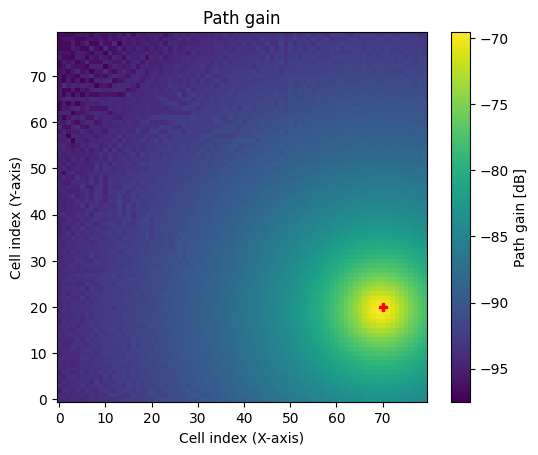

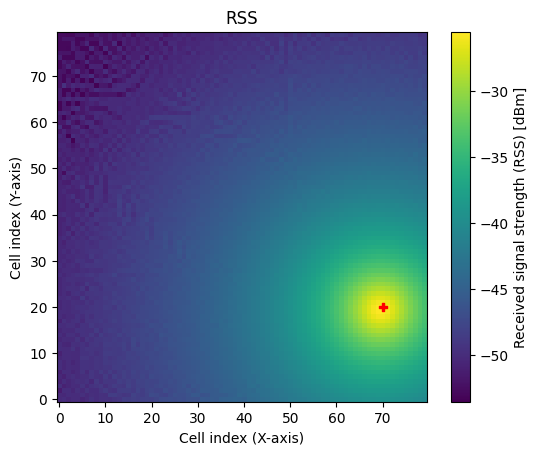

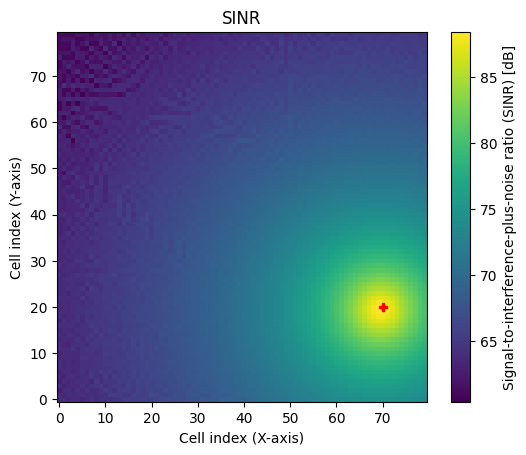

In [ ]:
# Visualize path gain
rm.show(metric="path_gain");

# Visualize received signal strength (RSS)
rm.show(metric="rss");

# Visulaize SINR
rm.show(metric="sinr");

O RSS depende da potência de transmissão, que pode ser modificada para cada
transmissor, conforme mostrado abaixo.

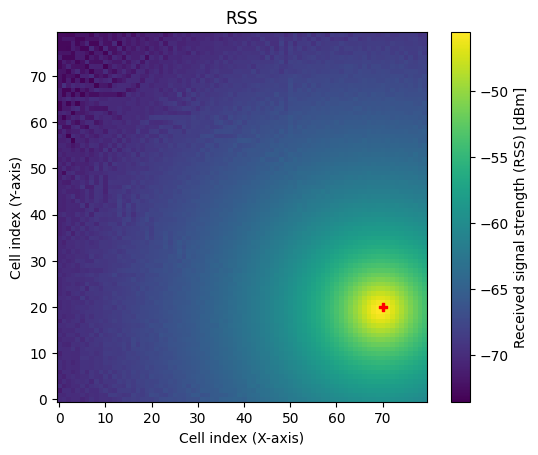

In [ ]:
tx0.power_dbm = 24
rm = rm_solver(scene,
               max_depth=5,
               samples_per_tx=10**7,
               cell_size=(5, 5),
               center=[0, 0, 0],
               size=[400, 400],
               orientation=[0, 0, 0])
rm.show(metric="rss");

Em comparação com a célula anterior, o RSS agora está 20 dB menor.

O SINR depende não apenas do RSS de outros transmissores na cena, mas
também da potência do ruído térmico. A potência do ruído é configurada indiretamente através das propriedades da cena
[largura de banda](https://nvlabs.github.io/sionna/rt/api/scene.html#sionna.rt.Scene.bandwidth) e [temperatura](https://nvlabs.github.io/sionna/rt/api/scene.html#sionna.rt.Scene.temperature).

Observe que nenhum desses parâmetros afeta o processo de ray tracing; eles são usados apenas para o cálculo da potência do ruído.

In [ ]:
print(f"Bandwidth: ", scene.bandwidth.numpy(), "[Hz]")
print(f"Temperature: ", scene.temperature.numpy(), "[K]")
print(f"Thermal noise power: ", watt_to_dbm(scene.thermal_noise_power).numpy(), "[dBm]")

Bandwidth:  [1000000.] [Hz]
Temperature:  [293.] [K]
Thermal noise power:  [-113.93048] [dBm]


Todas as métricas de um mapa de rádio podem ser acessadas diretamente como tensores, conforme mostrado na
próxima célula. Isso pode ser útil para definir novas métricas ou visualizar métricas de
uma forma diferente, como gráficos de CDF (Função de Distribuição Acumulada), etc.

In [ ]:
# Metrics have the shape
# [num_tx, num_cells_y, num_cells_x]

print(f'{rm.path_gain.shape=}') # Path gain
print(f'{rm.rss.shape=}') # RSS
print(f'{rm.sinr.shape=}') # SINR

# The location of all cell centers in the global coordinate system of the scene
# can be accessed via:
# [num_cells_y, num_cells_x, 3]
print(f'{rm.cell_centers.shape=}')

rm.path_gain.shape=(1, 80, 80)
rm.rss.shape=(1, 80, 80)
rm.sinr.shape=(1, 80, 80)
rm.cell_centers.shape=(80, 80, 3)


### Múltiplos transmissores

Para tornar as coisas mais interessantes, vamos adicionar mais dois transmissores
à cena e recalcular o mapa de rádio.

In [ ]:
# Remove transmitters here so that the cell can be executed multiple times
scene.remove("tx1")
scene.remove("tx2")

tx1 = Transmitter(name='tx1',
                  position=[-150, -100, 20],
                  orientation=[np.pi/6, 0, 0],
                  power_dbm=21)
scene.add(tx1)

tx2 = Transmitter(name='tx2',
                  position=np.array([0, 150 * np.tan(np.pi/3) - 100, 20]),
                  orientation=[-np.pi/2, 0, 0],
                  power_dbm=27)
scene.add(tx2)

rm = rm_solver(scene,
               max_depth=5,
               samples_per_tx=10**7,
               cell_size=(5, 5),
               center=[0, 0, 0],
               size=[400, 400],
               orientation=[0, 0, 0])

Assim que houver múltiplos transmissores em uma cena, podemos visualizar
uma métrica para um transmissor específico ou visualizar a métrica máxima entre todos
os transmissores. Esta última opção é relevante se quisermos inspecionar, por exemplo, o SINR em uma grande
cena, assumindo que um receptor sempre se conecta ao transmissor que fornece
o melhor SINR.

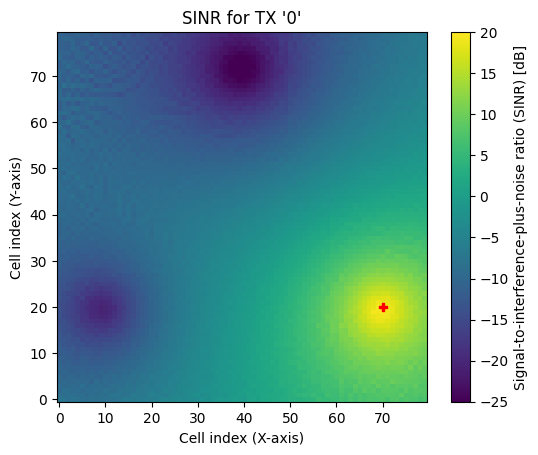

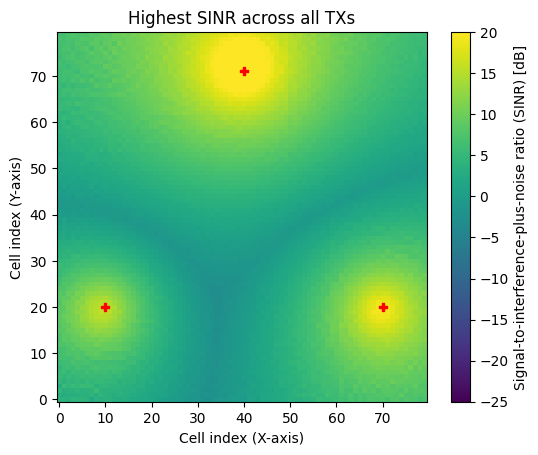

In [ ]:
# Show SINR for tx0
rm.show(metric="sinr", tx=0, vmin=-25, vmax=20);

# Show maximum SINR across all transmitters
rm.show(metric="sinr", tx=None, vmin=-25, vmax=20);

# Experiment: Change the metric to "path_gain" or "rss"
#             and play around with the parameters vmin/vmax
#             that determine the range of the colormap

Também podemos visualizar a função de distribuição acumulada (CDF) da métrica de interesse:

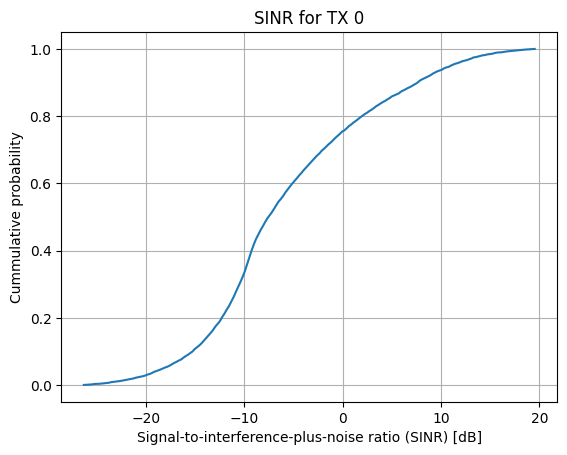

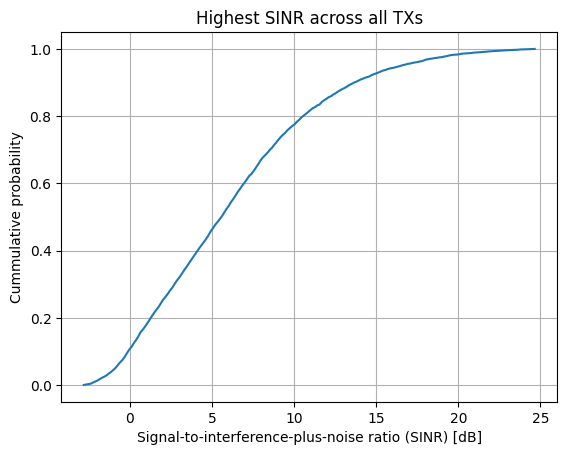

In [ ]:
# CDF of the SINR for transmitter 0
rm.cdf(metric="sinr", tx=0);

# CDF of the SINR if always the transmitter providing the best SINR is selected
rm.cdf(metric="sinr");

Observe que, em cada posição, o maior SINR entre *todos* os transmissores é
sempre mais favorável do que o SINR oferecido por um transmissor *específico* (em termos matemáticos,
o primeiro *domina estocasticamente* o último). Isso é claramente refletido na
forma das duas distribuições.

### Associação de usuários

Também é interessante investigar quais regiões de um mapa de rádio são "cobertas" por cada transmissor, ou seja, onde um transmissor fornece a métrica mais forte.
Você pode obter essa informação tanto como um tensor do método de classe [tx_association()](https://nvlabs.github.io/sionna/rt/api/radio_maps.html#sionna.rt.RadioMap.tx_association) quanto visualizá-la usando [show_association()](https://nvlabs.github.io/sionna/rt/api/radio_maps.html#sionna.rt.RadioMap.show_association).

rm.tx_association("sinr").shape=(80, 80)


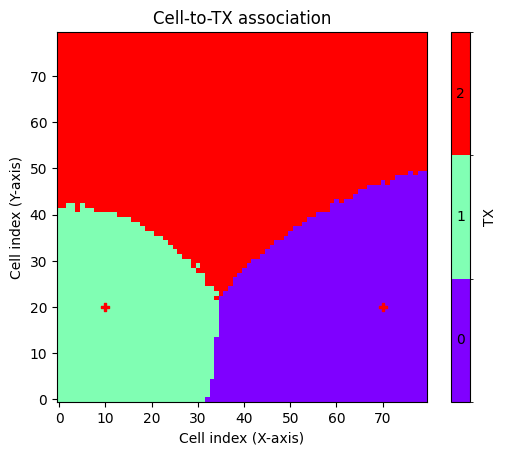

In [ ]:
# Get for every cell the tx index providing the strongest value
# of the chosen metric
# [num_cells_y, num_cells_x]
print(f'{rm.tx_association("sinr").shape=}')

rm.show_association("sinr");

### Amostragem de posições aleatórias de usuários

Em alguns casos, pode-se desejar posicionar receptores em posições aleatórias em uma cena
assegurando que as posições escolhidas tenham qualidade de sinal suficiente
(por exemplo, SINR)
e/ou estejam localizadas dentro de uma determinada faixa de um transmissor. O método
de classe [sample_positions()](https://nvlabs.github.io/sionna/rt/api/radio_maps.html#sionna.rt.RadioMap.sample_positions) foi projetado para este propósito, e você verá na próxima
célula como ele pode ser usado.

Você é encorajado a entender por que os dois critérios diferentes usados para a amostragem levam aos resultados observados.

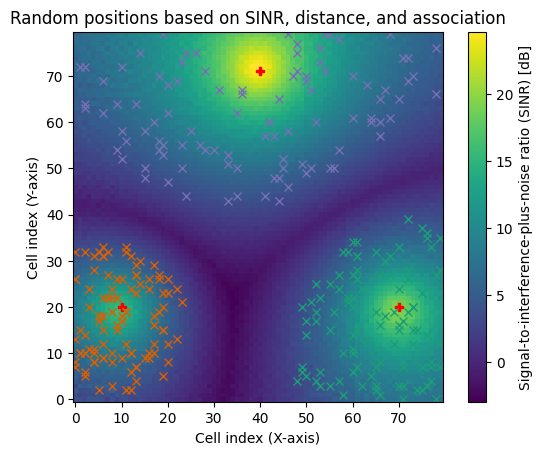

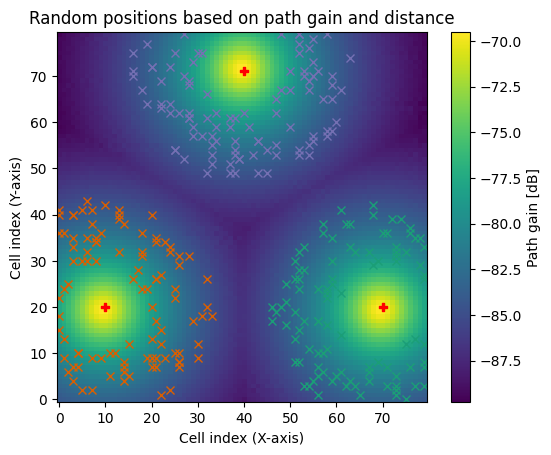

In [ ]:
pos, cell_ids = rm.sample_positions(
          num_pos=100,         # Number of random positions per receiver
          metric="sinr",       # Metric on which constraints and TX association will be applied
          min_val_db=3,        # Mininum value for the chosen metric
          max_val_db=20,       # Maximum value for the chosen metric
          min_dist=10,         # Minimum distance from transmitter
          max_dist=200,        # Maximum distance from transmitter
          tx_association=True, # If True, only positions associated with a transmitter are chosen,
                               # i.e., positions where the chosen metric is the highest among all TXs
          center_pos=False)    # If True, random positions correspond to cell centers,
                               # otherwise a random offset within each cell is applied

fig = rm.show(metric="sinr");
plt.title("Random positions based on SINR, distance, and association")
# Visualize sampled positions
for tx, ids in enumerate(cell_ids.numpy()):
    fig.axes[0].plot(ids[:,1], ids[:,0],
                     marker='x',
                     linestyle='',
                     color=mpl.colormaps['Dark2'].colors[tx])


pos, cell_ids = rm.sample_positions(
          num_pos=100,          # Number of random positions per receiver
          metric="path_gain",   # Metric on which constraints will be applied
          min_val_db=-85,        # Mininum value for the chosen metric
          min_dist=50,          # Minimum distance from transmitter
          max_dist=200,         # Maximum distance from transmitter
          tx_association=False, # If False, then a user located in a sampled position
                                # for a specific TX may perceive a higher metric from another TX!
          center_pos=False)     # If True, random positions correspond to cell centers,
                                # otherwise a random offset within each cell is applied

fig = rm.show(metric="path_gain");
plt.title("Random positions based on path gain and distance")
# Visualize sampled positions
for tx, ids in enumerate(cell_ids.numpy()):
    fig.axes[0].plot(ids[:,1], ids[:,0],
                     marker='x',
                     linestyle='',
                     color=mpl.colormaps['Dark2'].colors[tx])

### Antenas direcionais e vetores de pré-codificação

Conforme mencionado acima, os mapas de rádio dependem fortemente dos padrões de antena escolhidos e dos vetores de pré-codificação.
Na próxima célula, estudaremos seu impacto em um mapa de rádio por meio de várias visualizações.

Vamos começar atribuindo uma única antena a todos os transmissores e calculando o
mapa de rádio correspondente:

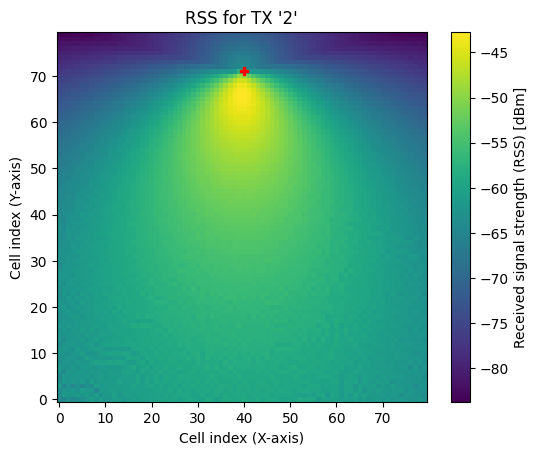

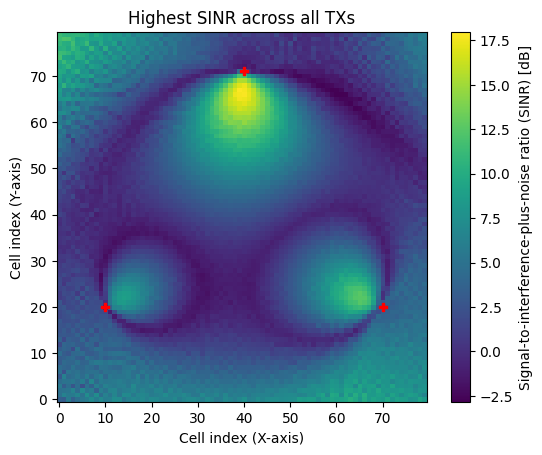

In [ ]:
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",   # Change to "iso" and compare the results
                             polarization="V")

rm = rm_solver(scene,
               max_depth=5,
               samples_per_tx=10**7,
               cell_size=(5, 5),
               center=[0, 0, 0],
               size=[400, 400],
               orientation=[0, 0, 0])

rm.show(metric="rss", tx=2);

rm.show(metric="sinr");

Agora adicionamos mais antenas ao array de antenas dos transmissores e aplicamos um
vetor de pré-codificação escolhido a partir de uma grade de feixes de Transformada Discreta de Fourier (DFT).

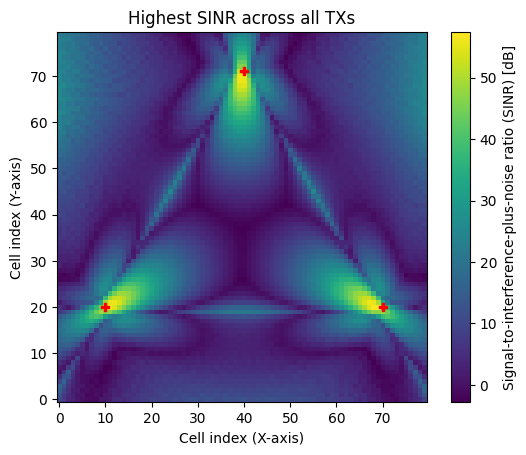

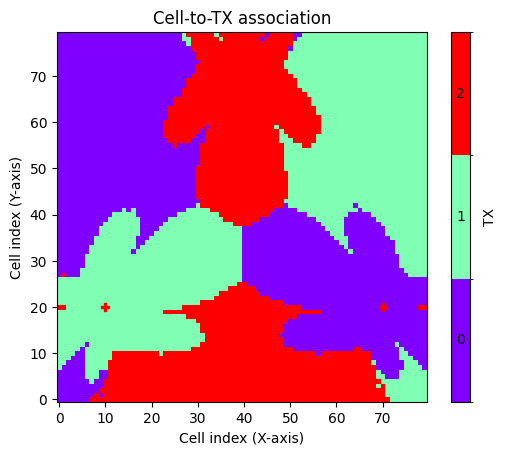

In [ ]:
# Number of elements of the rectangular antenna array
num_rows = 2
num_cols = 4

# Configure all transmitters to have equal power
tx0.power_dbm = 23
tx1.power_dbm = 23
tx2.power_dbm = 23

# Configure tr38901 uniform rectangular antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=num_rows,
                             num_cols=num_cols,
                             pattern="tr38901",
                             polarization="V")

# Create a common precoding vector used by all transmitters
# It is also possible to assign individual
precoding_vec = [1, -1]*4 / np.sqrt(8)

# Convert to tuple of Mitsuba vectors
precoding_vec = (mi.TensorXf(precoding_vec.real),
                 mi.TensorXf(precoding_vec.imag))

# Compute the radio map
rm = rm_solver(scene,
               max_depth=5,
               samples_per_tx=10**7,
               precoding_vec=precoding_vec,
               cell_size=(5, 5),
               center=[0, 0, 0],
               size=[400, 400],
               orientation=[0, 0, 0])

rm.show(metric="sinr");
rm.show_association(metric="sinr");

O uso de arrays de antenas e vetores de pré-codificação resulta em mapas de rádio complexos,
com aparência até artística, com regiões de associação de usuários às vezes contra-intuitivas.
No entanto, ainda podemos amostrar posições de usuários para cada transmissor.

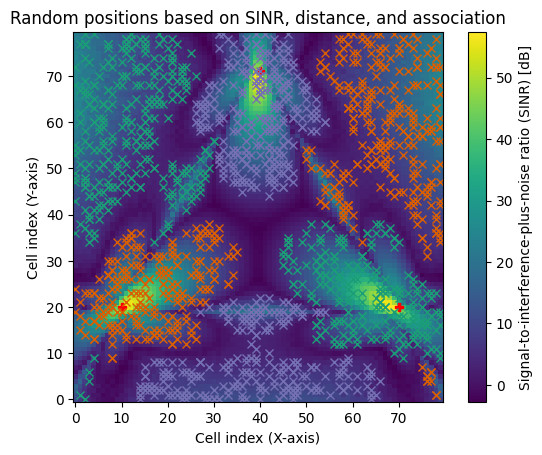

In [ ]:
pos, cell_ids = rm.sample_positions(
          num_pos=500,
          metric="sinr",
          min_val_db=3,
          min_dist=10,
          tx_association=True)

fig = rm.show(metric="sinr");

# Visualize sampled positions
for tx, ids in enumerate(cell_ids.numpy()):
    fig.axes[0].plot(ids[:,1], ids[:,0],
                     marker='x',
                     linestyle='',
                     color=mpl.colormaps['Dark2'].colors[tx])
plt.title("Random positions based on SINR, distance, and association");

## Mapa de rádio para uma cena realista

Até agora, analisamos apenas mapas de rádio em uma cena vazia. Vamos tornar as coisas mais interessantes
e carregar uma cena mais complexa, posicionar transmissores e inspecionar os resultados.

In [ ]:
def config_scene(num_rows, num_cols):
    """Load and configure a scene"""
    scene = load_scene(sionna.rt.scene.etoile)
    scene.bandwidth=100e6

    # Configure antenna arrays for all transmitters and receivers
    scene.tx_array = PlanarArray(num_rows=num_rows,
                                 num_cols=num_cols,
                                 pattern="tr38901",
                                 polarization="V")

    scene.rx_array = PlanarArray(num_rows=1,
                                 num_cols=1,
                                 pattern="iso",
                                 polarization="V")

    # Place transmitters
    positions = np.array(
                 [[-150.3, 21.63, 42.5],
                  [-125.1, 9.58, 42.5],
                  [-104.5, 54.94, 42.5],
                  [-128.6, 66.73, 42.5],
                  [172.1, 103.7, 24],
                  [232.8, -95.5, 17],
                  [80.1, 193.8, 21]
                 ])
    look_ats = np.array(
                [[-216, -21,0],
                 [-90, -80, 0],
                 [-16.5, 75.8, 0],
                 [-164, 153.7, 0],
                 [247, 92, 0],
                 [211, -180, 0],
                 [126.3, 194.7, 0]
                ])
    power_dbms = [23, 23, 23, 23, 23, 23, 23]

    for i, position in enumerate(positions):
        scene.add(Transmitter(name=f'tx{i}',
                              position=position,
                              look_at=look_ats[i],
                              power_dbm=power_dbms[i]))

    return scene

In [ ]:
# Load and configure scene
num_rows=8
num_cols=2
scene_etoile = config_scene(num_rows, num_cols)

# Compute the SINR map
rm_etoile = rm_solver(scene_etoile,
                      max_depth=5,
                      samples_per_tx=10**7,
                      cell_size=(1, 1))

Para obter uma visão geral da cobertura, vamos visualizar o mapa de rádio na visualização prévia (ou na imagem renderizada). Estas são alternativas ao método [show()](https://nvlabs.github.io/sionna/rt/api/radio_maps.html#sionna.rt.RadioMap.show) que utilizamos até agora, que também visualiza os objetos em uma cena.

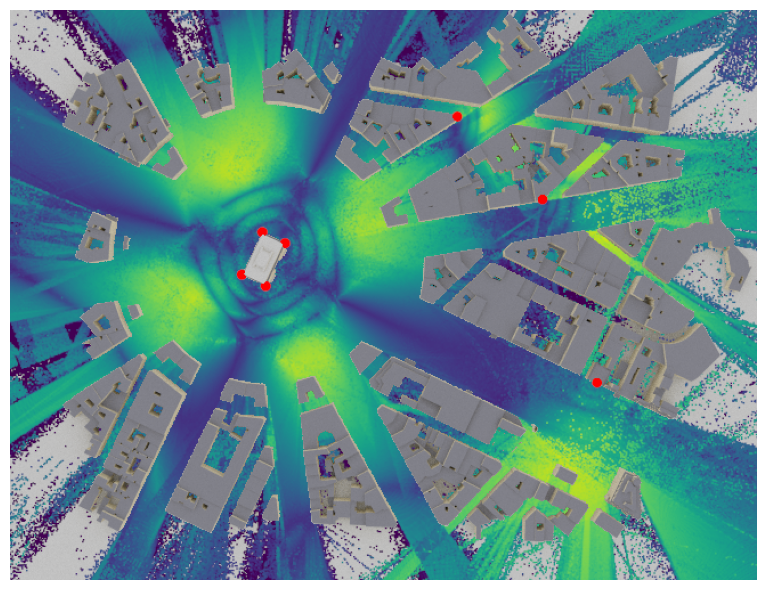

In [ ]:
if no_preview:
    # Render an image
    cam = Camera(position=[0,0,1000],
                     orientation=np.array([0,np.pi/2,-np.pi/2]))
    scene_etoile.render(camera=cam,
                        radio_map=rm_etoile,
                        rm_metric="sinr",
                        rm_vmin=-10,
                        rm_vmax=60);
else:
    # Show preview
    scene_etoile.preview(radio_map=rm_etoile,
                         rm_metric="sinr",
                         rm_vmin=-10,
                         rm_vmax=60)

### Channel impulse responses for random user locations

Com um mapa de rádio em mãos, podemos agora amostrar posições aleatórias onde posicionamos receptores reais e, em seguida, calcular as respostas impulsivas do canal.

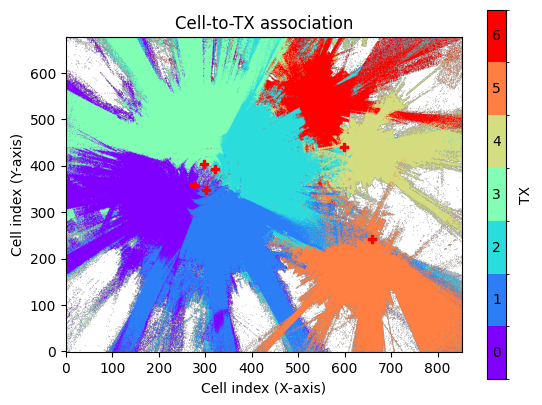

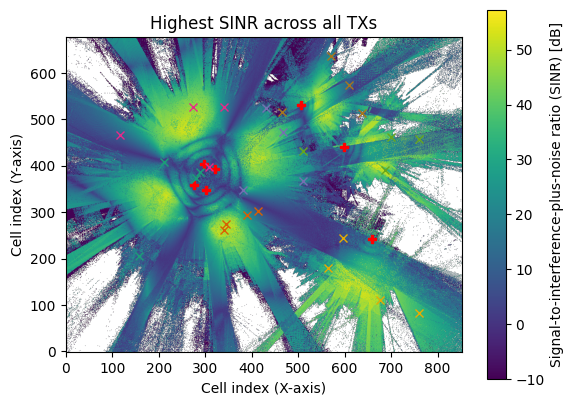

In [ ]:
rm_etoile.show_association("sinr");

pos, cell_ids = rm_etoile.sample_positions(
          num_pos=4,
          metric="sinr",
          min_val_db=3,
          min_dist=10,
          max_dist=200,
          tx_association=True)

fig = rm_etoile.show(metric="sinr", vmin=-10);

# Visualize sampled positions
for tx, ids in enumerate(cell_ids.numpy()):
    fig.axes[0].plot(ids[:,1], ids[:,0],
                     marker='x',
                     linestyle='',
                     color=mpl.colormaps['Dark2'].colors[tx])

In [ ]:
[scene_etoile.remove(rx.name) for rx in scene_etoile.receivers.values()]
for i in range(rm_etoile.num_tx):
    for j in range(pos.shape[1]):
        scene_etoile.add(Receiver(name=f"rx-{i}-{j}",
                           position=pos[i,j]))

p_solver = PathSolver()
paths = p_solver(scene_etoile, max_depth=5)

# Channel impulse response
a, tau = paths.cir()

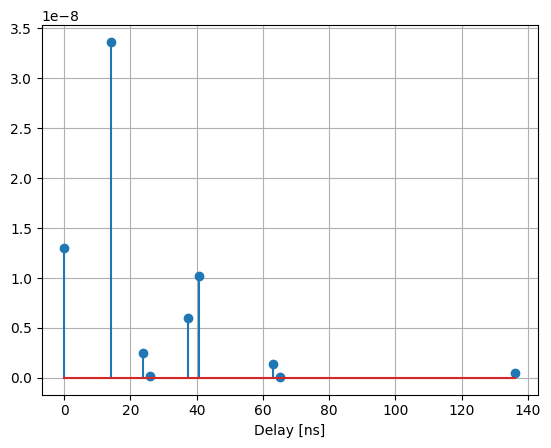

In [ ]:
# Transmitter and receiver indices to plot the channel impulse response
tx_index = 0
rx_index = 0

# Compute the squared magnitude of the path coefficients
a_abs_square = cpx_abs_square(a)
# # Sum over the transmit antennas
a_abs_square = np.sum(a_abs_square, axis=3)

# Get the selected path coefficients and delays in ns
a_abs_square = np.squeeze(a_abs_square)[rx_index, tx_index]
tau_ns = np.squeeze(tau)[rx_index, tx_index]*1e9

# Only keep the valid paths
valid = paths.valid.numpy()
valid = valid[rx_index, tx_index]
a_abs_square = a_abs_square[valid]
tau_ns = tau_ns[valid]

# Plot the channel impulse response
plt.figure()
plt.stem(tau_ns, a_abs_square)
plt.xlabel("Delay [ns]")
plt.grid(True)

## Mapas de rádio em malhas

Até agora, nos concentramos em mapas de rádio definidos por grades regulares planares de células. No entanto,
o Sionna RT também pode calcular mapas de rádio para malhas arbitrárias.
Neste caso, cada primitiva, ou seja, cada triângulo da malha, atua como uma célula para o cálculo do mapa de rádio.

Para ilustrar isso, vamos primeiro considerar uma cena vazia antes de avançar para uma configuração mais complexa.

In [ ]:
# Empty scene
scene = load_scene()

# Use a single antenna with directive pattern
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             pattern="tr38901",
                             polarization="V")

# Add a transmitter
scene.add(Transmitter(name="tx",
                      position=[0, 0, 0],
                      orientation=[0, 0, 0]))

Agora vamos carregar uma malha esférica e calcular o mapa de rádio para ela.

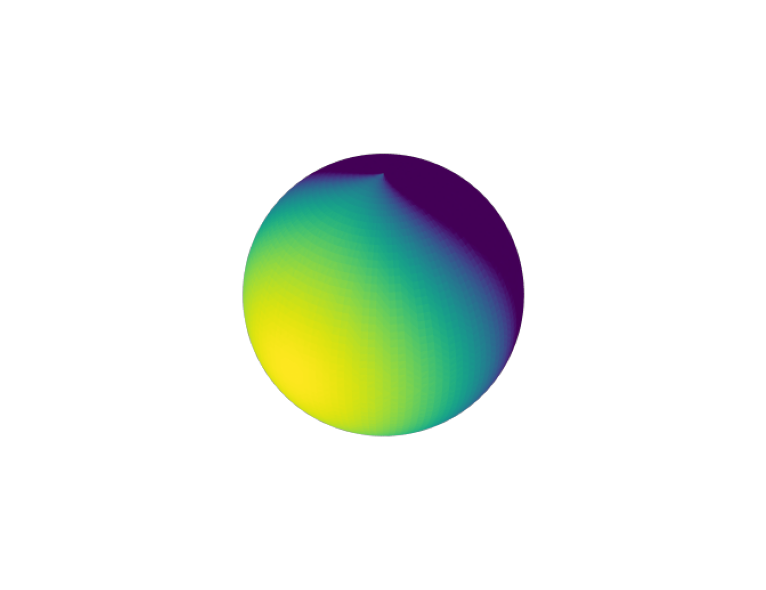

In [ ]:
# Load the mesh of a sphere
sphere = load_mesh(sionna.rt.scene.sphere)

# Instantiate the radio map solver
rm_solver = RadioMapSolver()

# Compute radio map using the sphere as the measurement surface
rm = rm_solver(scene,
               measurement_surface=sphere,
               samples_per_tx=10**7)

if no_preview:
    cam = Camera(position=[4, 3, 4])
    cam.look_at(np.array([0, 0, 0]))
    scene.render(camera=cam,
                 radio_map=rm);
else:
    scene.preview(radio_map=rm);

Com a esfera centrada na origem e o transmissor também posicionado na origem, esta configuração permite a visualização do padrão de antena conforme é projetado na esfera.
Esta configuração é igualmente eficaz para visualizar o padrão de feixe de um
array de antenas. Em contraste com um mapa de rádio planar, a resolução da
superfície de medição é determinada pelo tamanho das primitivas, que não pode ser
configurado dinamicamente. Se desejar uma
maior resolução, você deve usar uma superfície com uma malha mais refinada.

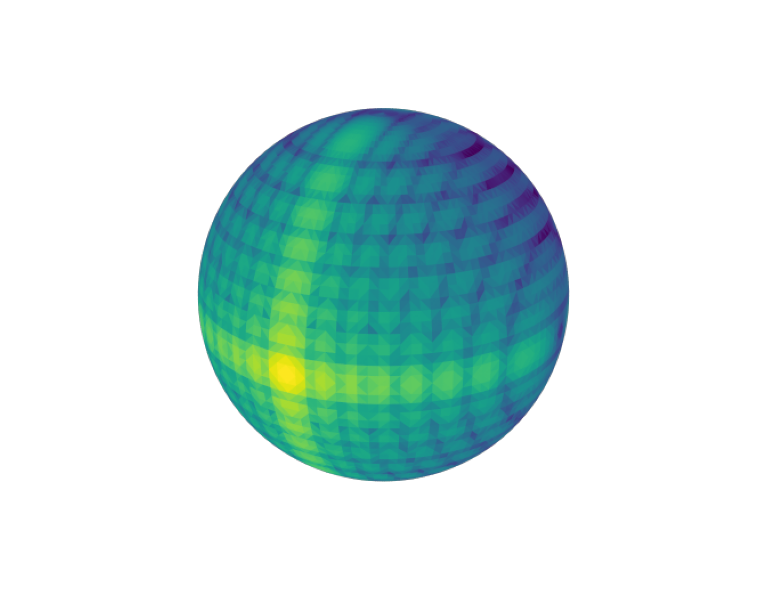

In [ ]:
# Use an 16x16 antenna array with directive pattern
scene.tx_array = PlanarArray(num_rows=16,
                             num_cols=16,
                             pattern="tr38901",
                             polarization="V")

# Compute radio map using the sphere as the measurement surface
rm = rm_solver(scene,
               measurement_surface=sphere,
               samples_per_tx=10**7)

if no_preview:
    cam = Camera(position=[4, 2, 2])
    cam.look_at(np.array([0, 0, 0]))
    scene.render(camera=cam,
                 radio_map=rm);
else:
    scene.preview(radio_map=rm);

Vamos agora explorar um cenário mais realista.

Uma aplicação prática dos mapas de rádio baseados em malha é calculá-los para terrenos com formatos arbitrários. Para demonstrar isso, vamos carregar uma cena com um terreno complexo.

In [ ]:
# Load a scene with a complex terrain
scene = load_scene(sionna.rt.scene.san_francisco)

# Use a single antenna with isotropic pattern
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             pattern="iso",
                             polarization="V")

# Add a transmitter+
scene.add(Transmitter(name="tx",
                      position=[468, 106, 70],
                      orientation=[0, 0, 0],
                      display_radius=5))

Agora vamos gerar um mapa de rádio para uma superfície que espelha o formato do terreno e corre paralela a ele, posicionada 1,5 metro mais alta.
Para conseguir isso, vamos clonar o terreno da cena e deslocá-lo para cima ao longo do eixo z.

In [ ]:
# Clone the terrain mesh
mesurement_surface = scene.objects["Terrain"].clone(as_mesh=True)
# Shift the terrain upwards by 1.5 meters
transform_mesh(mesurement_surface, translation=np.array([0, 0, 1.5]))

Em seguida, vamos calcular um mapa de rádio para a superfície de medição.

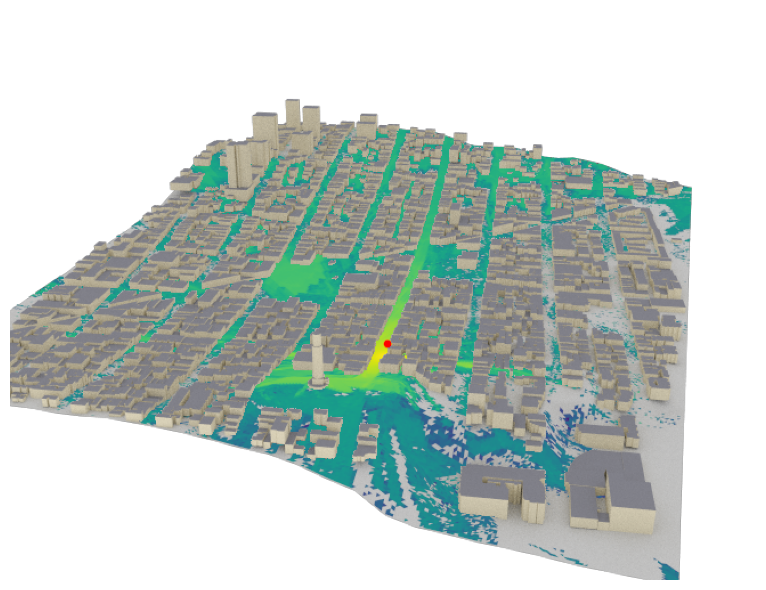

In [ ]:
# Compute radio map using the measurement surface
rm = rm_solver(scene,
               measurement_surface=mesurement_surface,
               samples_per_tx=10**8,
               max_depth=5)

if no_preview:
    cam = Camera(position=[1400, 400, 575])
    cam.look_at(np.array([310, 50, 60]))
    scene.render(camera=cam,
                 radio_map=rm);
else:
    scene.preview(radio_map=rm, rm_vmin=-100);

A estrutura complexa do terreno afeta significativamente a cobertura, como ilustrado aqui. A esfera vermelha marca a posição do transmissor.

## Conclusions

Os mapas de rádio são um recurso extremamente versátil do Sionna RT. Eles são particularmente
úteis para definir áreas significativas para posicionamento aleatório de usuários que atendam a certas
restrições de RSS ou SINR, ou para investigar o posicionamento e
configuração de transmissores em uma cena.

No entanto, mal arranhamos a superfície de seu potencial. Por exemplo,
observe que as métricas de um mapa de rádio são diferenciáveis em relação à maioria
dos parâmetros da cena, como orientações dos transmissores, potência de transmissão,
padrões de antena, vetores de pré-codificação e assim por diante. Isso
abre uma ampla gama de possibilidades para otimização baseada em gradiente.

Esperamos que você tenha achado este tutorial sobre mapas de rádio no Sionna RT informativo.
Encorajamos você a colocar a mão na massa, realizar seus próprios experimentos e aprofundar seu entendimento
sobre ray tracing. Sempre há mais para aprender, então não deixe de explorar nossos outros
[tutoriais](https://nvlabs.github.io/sionna/rt/tutorials.html) também!